/var/folders/37/zl466gdn7dq0sbr5l5xymmb00000gn/T/ipykernel_59994/1158414631.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: mps


Sampling: 100%|██████████| 1000/1000 [00:00<00:00, 1352.69it/s]


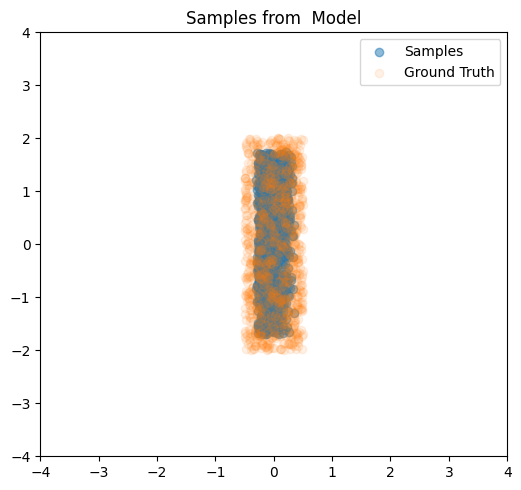

In [3]:
# sample_models.ipynb
%load_ext autoreload
%autoreload 2

import torch
from model import ScoreNet
from sampler import reverse_sde_sampling  # sampler now uses the combined score internally
import matplotlib.pyplot as plt
from data import generate_all_datasets

# Set up device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

checkpoint_path = "checkpoints/Rectangle.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Initialize the models with the same architecture used during training
score_net1 = ScoreNet().to(device)

# Load the saved weights
score_net1.load_state_dict(checkpoint['score_net1_state_dict'])


score_net1.eval()


# Sampling parameters
num_samples = 1000
num_diffusion_timesteps = 1000

# Generate samples using the combined score (averaging the two networks)
samples = reverse_sde_sampling(
    score_net1=score_net1,
    num_samples=num_samples,
    num_diffusion_timesteps=num_diffusion_timesteps,
    device=device,
    x_shape=(2,)
)

# Generate the truth dataset for comparison (e.g., using the 'Gaussian Mixture')
n_samples = 1000
all_datasets = generate_all_datasets(n_samples)
truth = all_datasets['Rectangle']

# Plot the generated samples vs. the ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(
    samples[:, 0].detach().cpu().numpy(),
    samples[:, 1].detach().cpu().numpy(),
    alpha=0.5,
    label='Samples'
)
plt.scatter(
    truth[:, 0].detach().cpu().numpy(),
    truth[:, 1].detach().cpu().numpy(),
    alpha=0.1,
    label='Ground Truth'
)
plt.title("Samples from  Model")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend()

plt.tight_layout()
plt.show()


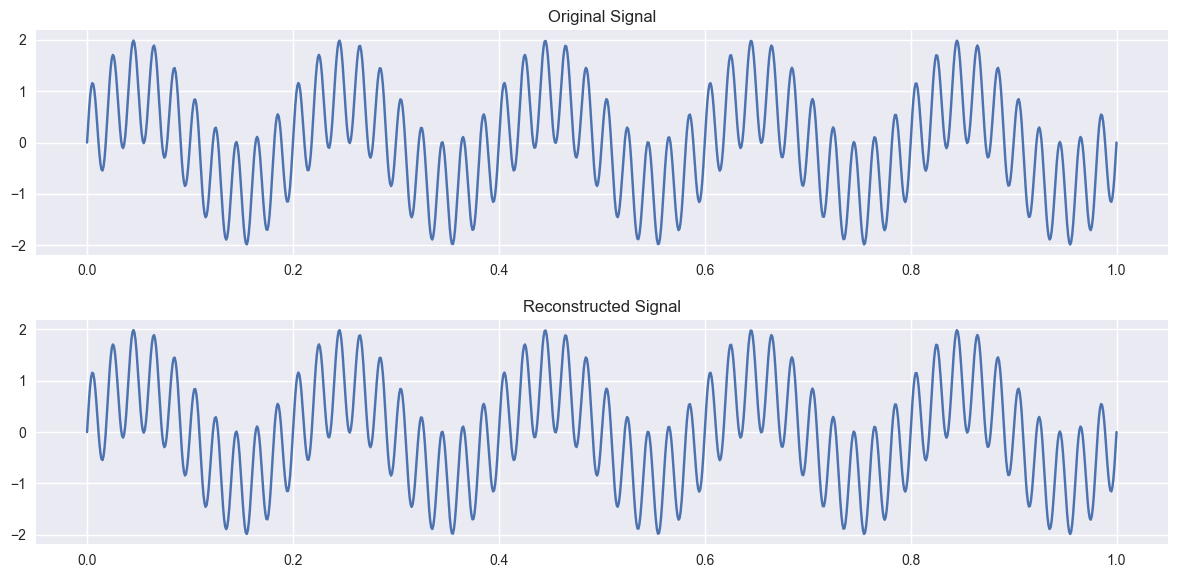

In [32]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Create a sample time series
t = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 50 * t)

# Choose wavelet family
wavelet = 'db4'  # Daubechies 4

# Decomposition
coeffs = pywt.wavedec(signal, wavelet, level=5)

# coeffs[0] contains the approximation coefficients
# coeffs[1:] contains the detail coefficients (finest to coarsest)

# Modify coefficients if desired (e.g., for denoising)
# coeffs[1] = np.zeros_like(coeffs[1])  # Remove finest detail level

# Reconstruction
reconstructed_signal = pywt.waverec(coeffs, wavelet)

# Plot original and reconstructed signals
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(t, signal)
plt.title('Original Signal')
plt.subplot(212)
plt.plot(t[:len(reconstructed_signal)], reconstructed_signal)
plt.title('Reconstructed Signal')
plt.tight_layout()
plt.show()